In [ ]:
# | echo: false
# | output: false
from fastcore.test import *
from IPython.display import Markdown
import json
import math
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from pathlib import Path
import requests
import torch
import torch.nn as nn
from torch.nn import functional as F
from typing import Any, Callable, Dict, Iterable, Sequence, Tuple
from tqdm.notebook import tqdm

## Motivation
1. Engage with the transformer architecture deeply
2. Produce mechanistic explanations for 3 unique patterns the transformer gets right. 
3. Develop the facility with PyTorch and the math to do this analysis. 

## Hyperparameters

In [ ]:
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_interval=500
eval_iters=200
n_embed = 384

max_iters = 5000
learning_rate = 3e-4

n_head = 6
n_layer = 6
dropout = 0.2

print(f"device is {device}")

device is cpu


In [ ]:
# Set a manual seed so output is deterministic (used same value as @karpathy)
torch.manual_seed(1337)

<torch._C.Generator>

## Download and Process Training Data

Much of this code is straight from @karpathy's video.

In [ ]:
# Download TinyShakespeare
input_file = Path('./input.txt')
if not input_file.exists():
    url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    r = requests.get(url)
    input_file.write_text(r.text)

In [ ]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create mappings
stoi = { ch: i for i, ch in enumerate(chars) }
itos = { i: ch for i, ch in enumerate(chars) }

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

## Model Definition
All of this code is taken from @karpathy's video

In [ ]:
class Head(nn.Module):
    """One self-attention head"""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)

        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        v = self.value(x)
        out = wei @ v 
        return out 

In [ ]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of self attention in parallel"""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [ ]:
class FeedForward(nn.Module):

    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
class Block(nn.Module):
    """One transformer block"""

    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1  = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

        
    def forward(self, x): 
        x = x + self.sa(self.ln1(x)) # The `x +` part is a skip connection
        x = x + self.ffwd(self.ln2(x)) # The `x +` part is a skip connection

        return x

In [ ]:
class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(
            *[Block(n_embed, n_head=n_head) for _ in range(n_layer)]
        )
        self.ln_f = nn.LayerNorm(n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        token_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, n_embed)
        x = token_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None: 
            loss = None 
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss 

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices
        for _ in range(max_new_tokens):
            # crop idx to last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get predictions
            logits, loss = self(idx_cond) # logits is (B, T, C)

            # focus only on the last time step
            logits = logits[:, -1, :] # logits is now (B, 1, C)
            probs = F.softmax(logits, dim=1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = TransformerLanguageModel()
m.to(device)

TransformerLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwis

In [ ]:
# Peek at the model size
trainable_params = [p for p in m.parameters() if p.requires_grad]
nparams = sum([np.prod(p.size()) for p in trainable_params])
nparams

10788929

In [ ]:
# Load the model from a saved file
m.load_state_dict(torch.load('./shakespeare.pt', map_location=torch.device(device)))
m.eval()

TransformerLanguageModel(
  (token_embedding_table): Embedding(65, 384)
  (position_embedding_table): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=384, out_features=64, bias=False)
            (query): Linear(in_features=384, out_features=64, bias=False)
            (value): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((384,), eps=1e-05, elementwis

In [ ]:
# Helper function to generate text
def str_to_tensor(s: str):
    return torch.tensor([encode(s)], dtype=torch.long, device=device)

def generate(m: TransformerLanguageModel, initial_text: str, max_new_tokens=100):
    input = str_to_tensor(initial_text)
    return decode(m.generate(input, max_new_tokens=max_new_tokens)[0].tolist())



In [ ]:
print(generate(m, 'Hello'))

Hellowful provide the instrument to use.

CORIOLANUS:
Great of this desperate lies! Dost most war;
This m


In [ ]:
# Generate some longer text
print(generate(m, '\n', max_new_tokens=1000))


AEdile:
How she she beg'd stop, alas, bewits of this
grood fellowship, I had rood thy sheet how I die.
Do you for your brows, I could not follow thee
Caesar, and fall not a thousand comes to Margaret.

FRIAR LAURENCE:
Thou hast hast no prized her brother,
To brief for your prayers and enemy day
With the country's mortal; thou knew me too
And well meet off our Roman to till this:
Subdue, as prey you.

FRIAR LAURENCE:
Thus is the friendly of my wilt.

HASTINGS:

FRIAR LAURENCE:
How now! what a hare you gentleman?

HENRY BOLINGBROKE:
No, I then that a kingdom
To the duke is censured:
I cannot be short shall discold I to it.
Is Stanley? then for my lord, I am so?
Say you that were not leave done to me,
Nor but smiles, though nothing stow of kings.

HENRY BOLINGBROKE:
To tell me to you and more your father's wounds:'
He is not as a last,--a little excellenting on

ESCERLAND:
He shugs us of down your father's lady,--

KING RICHARD II:
Be it not too much quarrel: and I pray thee, sir,
Come t

## Helper functions for encoding/decoding embeddings


In [ ]:
def encode_input(s: str):
    """Given a string, performs the token and positional embeddings
    done at the beginning of the model and returns the tensor that
    would be sent into the stack of blocks."""
    idx = str_to_tensor(s)
    idx = idx[:, -block_size:]

    # Logic from the model's forward() function
    B, T = idx.shape
    token_emb = m.token_embedding_table(idx)
    pos_emb = m.position_embedding_table(torch.arange(T, device=device))  # (T, n_embed)
    x = token_emb + pos_emb 
    return x.detach()   

In [ ]:
def logits_from_embedding(x: torch.Tensor) -> torch.Tensor:
    """Given an embedding, runs the final layernorm and lm_head layers
    of the model and returns the logits."""
    x = m.ln_f(x)
    logits = m.lm_head(x)
    return logits.detach()

In [ ]:
def probs_from_logits(logits: torch.Tensor) -> torch.Tensor:
    """Given logits output by the final layer of the model, converts
    them into probabilities for the next output token."""
    logits = logits[:, -1, :]
    probs = F.softmax(logits, dim=1)
    return probs.detach()


In [ ]:
def probs(x: torch.Tensor) -> torch.Tensor:
    """Given an embedding, returns the probabilities for the next output token.
    Basically a wrapper around probs_from_logits(logits_from_embeddding(x))"""
    logits = logits_from_embedding(x)
    return probs_from_logits(logits)


In [ ]:
def plot_probs(prob_values: torch.Tensor, title: str=''):
    """Given a tensor of probabilities, plots them as a bar graph"""
    fig = plt.figure(figsize=(12, 4))

    x_indices = np.arange(vocab_size)
    x_labels = [repr(c)[1:-1] for c in chars]

    ax = fig.add_subplot(1, 1, 1)
    ax.bar(x_indices, prob_values)
    ax.set_xticks(x_indices, x_labels, rotation='vertical')
    ax.set_title(title)
    ax.set_ylim(0., 1.)

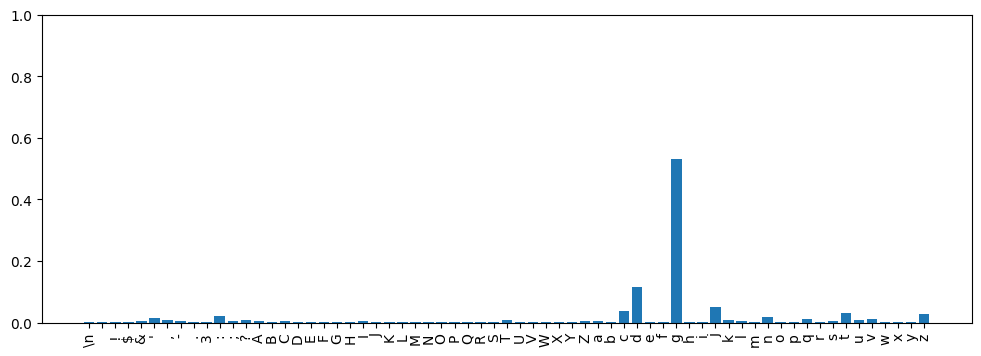

In [ ]:
plot_probs(probs(encode_input('Citizen'))[0])

In [ ]:
def topk_chars(x: torch.Tensor, k: int):
    """Computes the k chars with the highest probability of being picked next, 
    given the embedding `x`. `x` should be of shape B, T, C but only the last
    `T` will be considered."""
    
    B, _, C = x.shape
    assert B == 1 # assume 1 batch for analysis
    assert C == n_embed # last dimension should be an embedding

    p = probs(x)
    sorted_p, indices = torch.sort(p, dim=-1, descending=True)
    result = [
        (itos[indices[0][i].item()], sorted_p[0][i].item())
        for i in range(k)
    ]
    return result

In [ ]:
topk_chars(encode_input('Citizen'), k=5)

[('g', 0.5310670733451843),
 ('d', 0.11407259851694107),
 ('j', 0.0494547113776207),
 ('c', 0.03623943403363228),
 ('t', 0.030849244445562363)]

## Helpers to run the model with parts selectively enabled

In [ ]:
def run_model(s: str, blocks: Iterable[nn.Module]):
    """Run the model against an input string, using the specified blocks
    instead of the ones built into the model."""
    assert len(blocks) == n_layer

    blocks_module = nn.Sequential(*blocks)

    x = encode_input(s)
    x = blocks_module(x)
    logits = logits_from_embedding(x)

    return logits


In [ ]:
# Verify that run_model called with all the blocks in the real model produces
# the same result
out1 = run_model('Citizen', [
    m.blocks[0],
    m.blocks[1],
    m.blocks[2],
    m.blocks[3],
    m.blocks[4],
    m.blocks[5],
])

out2, _ = m(str_to_tensor('Citizen'))

test_eq(out1.detach(), out2.detach())

In [ ]:
class InputOutputAccessor:
    def __init__(self, activations: Dict[str, Tuple]):
        self.activations = activations

    def inputs(self, name: str) -> Tuple[torch.Tensor]:
        return self.activations[name][0]
    
    def input(self, name: str) -> torch.Tensor:
        inps = self.inputs(name)
        assert len(inps) == 1
        return inps[0]
    
    def output(self, name: str) -> torch.Tensor:
        return self.activations[name][1]

def copy_block_from_model(block_idx: int):
    """Given the index of a block in the model [0, n_layer), creates
    a new block with identical parameters.
    
    Returns
    -------
    Tuple
        First element is the new block, second is an `InputOutputAccessor` that
        provices access to the inputs and outputs of the block itself, it top-level 
        sub-modules, and children of the self-attention sub-module.
    """
    block = m.blocks[block_idx]
    new_block = Block(n_embed, n_head)
    new_block.load_state_dict(block.state_dict())
    new_block.eval()

    activations = {}
    def log_activation_hook(name):
        def hook(_, input, output):
            inputs = tuple([inp.detach() for inp in input])
            activations[name] = (inputs, output.detach())
        return hook 
    
    new_block.register_forward_hook(log_activation_hook('.'))
    for name, module in new_block.named_children():
        module.register_forward_hook(log_activation_hook(name))

    # Register the hook for the self-attention layer's children as 
    # I will need this. Wanted this function to not have to know 
    # about the internal structure of a block (i.e. not access members
    # by a specific name), so this is unfortunate, but the most expedient. 
    for name, module in new_block.sa.named_children():
        module.register_forward_hook(log_activation_hook(f'sa.{name}'))


    return new_block, InputOutputAccessor(activations)

In [ ]:
# Test block copying
block_idx = 0
old_b = m.blocks[block_idx]
new_b, io_accessor = copy_block_from_model(block_idx)
test_eq(new_b is old_b, False)

x = encode_input('Citizen')
old_result = old_b(x).detach()
new_result = new_b(x).detach()
test_eq(old_result, new_result)
test_eq(io_accessor.input('.'), x)
test_eq(io_accessor.output('.'), new_result)

In [ ]:
class NoOpHead(nn.Module):
    """Head that just returns the portion of the input vector that a real head
    in this position would modify in the output."""
    def __init__(self, head_size, head_idx):
        super().__init__()
        self.head_size = head_size
        self.head_idx = head_idx

    def forward(self, x):
        return x[
            :,
            :,
            self.head_idx * self.head_size : self.head_idx * self.head_size
            + self.head_size,
        ]
    

def copy_block_from_model_and_disable_heads(block_idx: int, disable_heads: Iterable[int]):
    """Copy a block from the model with the given index, but replace the heads
    whose indices are in `disable_heads` with no-op heads.
    
    Returns
    -------
    Tuple
        same as return value from `copy_block_from_model()`"""
    block, io_accessor = copy_block_from_model(block_idx)
    head_size = n_embed // n_head
    for head_idx in disable_heads:
        assert head_idx < n_head
        no_op_head = NoOpHead(head_size, head_idx)
        no_op_head.eval()
        block.sa.heads[head_idx] = no_op_head
    return block, io_accessor

In [ ]:
"""Integration test to show that NoOpHead works as expected in a block

Create a regular block and a block with one head disabled. Show that the 
outputs of the self attention heads within the two blocks are identical, 
except for in the region of the disabled head. In the region of the disabled
head, the output should be identical to the heads' input. 

We have to look at the self-attention heads' output, not the output of the 
block as a whole. The differences will be isolated to the disabled head's 
position in the self-attention heads output, but not after that. Any differences
will propagate to the rest of the tensor because of the projection layer after
the attention heads and the layernorm at the end of the block. 
"""
# Create a regular block
block0_reg, io_reg = copy_block_from_model(block_idx=0)

# Create a block with a disabled head
disable_head_idx = 5
block0_noh5, io_noh5 = copy_block_from_model_and_disable_heads(
    block_idx=0, disable_heads=[disable_head_idx]
)

# Run both blocks against the same input
x = encode_input('Citizen')
block0_reg(x)
block0_noh5(x)

# Get the output of the self-attention heads for each block. Note the output of the
# heads is the input to the `proj` layer
reg_out = io_reg.input('sa.proj')
noh5_out = io_noh5.input('sa.proj')

# Test that outputs are identical except where h5 output would be written
head_size = n_embed // n_head
test_eq(
    reg_out[:, :, 0 : disable_head_idx * head_size],
    noh5_out[:, :, 0 : disable_head_idx * head_size],
)
test_eq(
    reg_out[:, :, (disable_head_idx + 1) * head_size :],
    noh5_out[:, :, (disable_head_idx + 1) * head_size :],
)

# Test that the portion of the output where h5 would have been written is
# identical to the self-attention's input in that portion.
sa_input = io_noh5.input('sa')
test_eq(
    noh5_out[:, :, disable_head_idx * head_size : (disable_head_idx + 1) * head_size],
    sa_input[:, :, disable_head_idx * head_size : (disable_head_idx + 1) * head_size],
)

## Helpers to Extract Intermediate Values from a Run of the Model


In [ ]:
def get_block_intermediates(s: str) -> Sequence:
    """Runs the model with the given string and returns the intermediate
    values computed by and within each block.
    
    Returns
    -------
    Sequence
        The element at index i is a tuple containing the intermediate values 
        from block i in the transformer. The elements of each tuple are: 
         - Input to the block 
         - Output of the self-attention layer within the block
         - Output of the feed-forward layer within the block
         - Output of the block
    """
    blocks, io_accessors = zip(*[ # See https://stackoverflow.com/a/13635074
        copy_block_from_model(block_idx=i)
        for i in range(n_layer)
    ])

    _ = run_model(s, blocks)

    return [
        (
            io_accessors[i].input('.'), 
            io_accessors[i].output('sa'),
            io_accessors[i].output('ffwd'),
            io_accessors[i].output('.'), 
        )
        for i in range(n_layer)
    ]

## Replicate Logit Lens

[This post](https://www.lesswrong.com/posts/AcKRB8wDpdaN6v6ru/interpreting-gpt-the-logit-lens) introduces the "logit lens", a way of interpreting the intermediate layers of a transformer. 

In [ ]:
def get_input_and_correct(data: torch.Tensor = val_data, fragment_size=16, start_idx=0):
    """Return a fragment from a given corpus and the "correct" values for
    the next token at each position."""
    input = data[start_idx : start_idx + fragment_size]
    correct = data[start_idx + 1 : start_idx + fragment_size + 1]

    return decode(input.tolist()), decode(correct.tolist())

In [ ]:
def logit_lens(s: str):
    intermediates = get_block_intermediates(s)
    embeddings = [intermediates[0][0]]  # Start with the input to the first layer

    # Add the output from each block
    embeddings.extend([block_output for _, _, _, block_output in intermediates])

    top1_preds = []
    top1_probs = []
    for emb in embeddings:
        logits = logits_from_embedding(emb)  # B, T, vocab_size
        top1 = torch.argmax(
            logits, dim=-1, keepdim=False
        )  # B, T - each item in T dimension is an index in range(0, vocab_size)
        top1_chars = decode(top1[0].tolist())  # string of length T
        top1_preds.append(top1_chars)
        all_probs = F.softmax(logits, dim=-1)  # B, T, vocab_size
        probs = [all_probs[0][i][j].item() for i, j in enumerate(top1[0])]
        top1_probs.append(probs)

    return top1_preds, top1_probs


def plot_logit_lens(s: str, correct: str):
    top1_preds, top1_probs = logit_lens(s)

    # Reverse both results so that the last layer is at the top
    top1_preds.reverse()
    top1_probs.reverse()

    nx = len(s)
    ny = len(top1_preds)

    fig, ax = plt.subplots(1, 1, figsize=(1.2 * nx, 20))
    im = ax.imshow(top1_probs, cmap='viridis')
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels([repr(c)[1:-1] for c in s], fontsize=16)

    ax.set_yticks(range(ny))
    ax.set_yticklabels([f"Block {i -1}" for i in range(ny, 0, -1)])

    ax_top = ax.secondary_xaxis('top')
    ax_top.set_xticks(range(len(s)))
    ax_top.set_xticklabels([repr(c)[1:-1] for c in correct], fontsize=16)

    im.set_clim(vmin=0, vmax=1)
    plt.colorbar(im, ax=[ax], location='top')

    for y in range(ny):
        for x in range(nx):
            fontweight = 'bold' if top1_preds[y][x] == correct[x] else None
            plt.text(x, y, top1_preds[y][x], fontweight=fontweight, fontsize=16)

In [ ]:
input, correct = get_input_and_correct(val_data, start_idx=50)
print(f"INPUT  : {repr(input)}"), 
print(f"CORRECT: {repr(correct)}")


INPUT  : 'STA:\nGood morrow'
CORRECT: 'TA:\nGood morrow,'


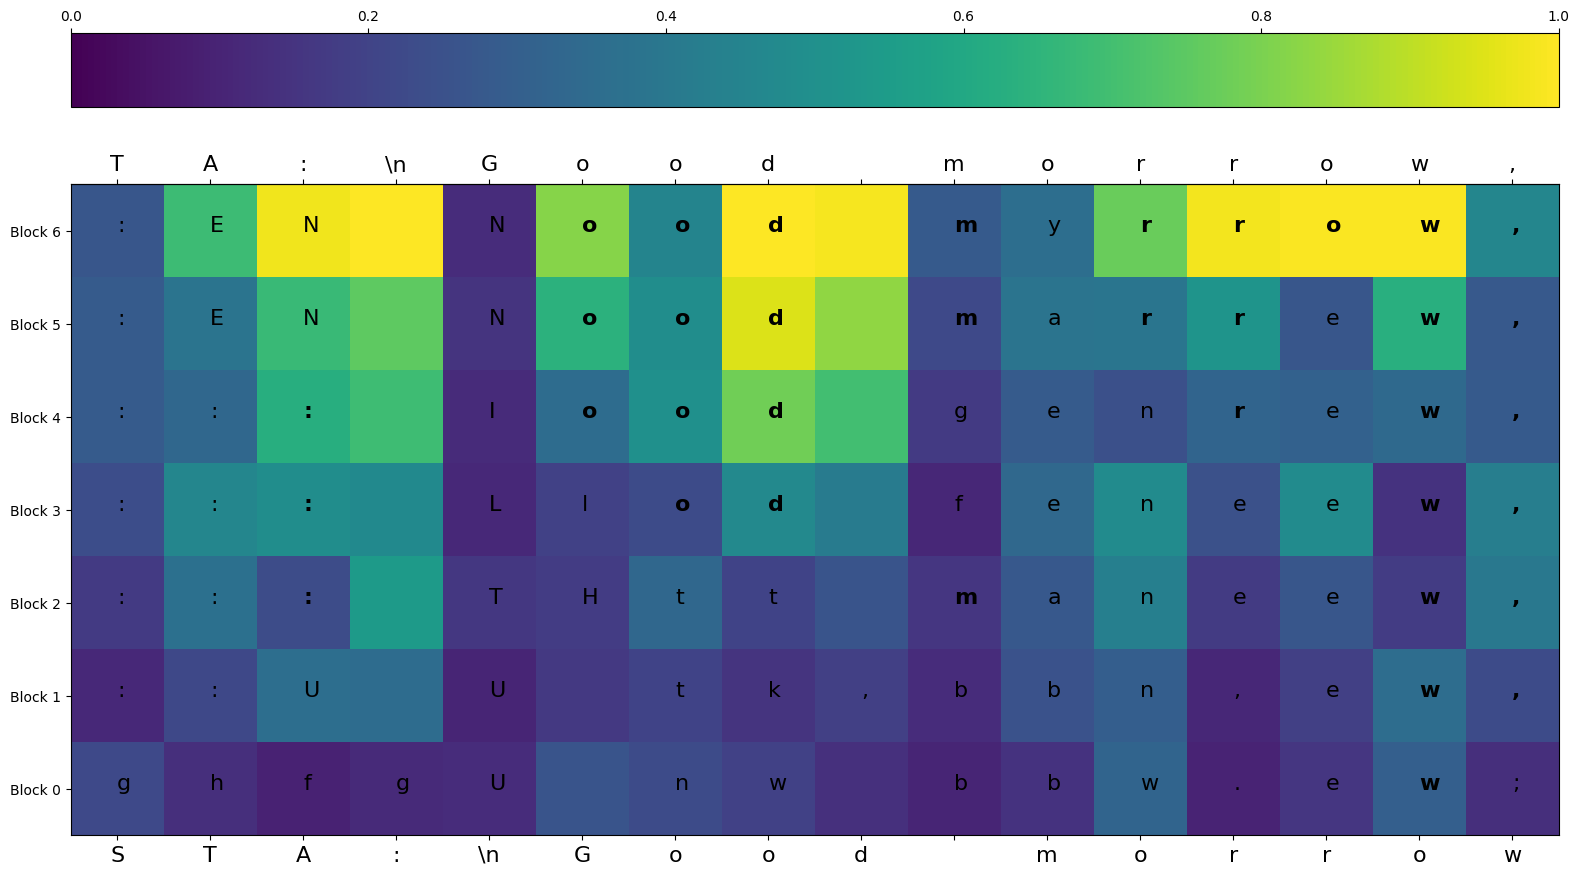

In [ ]:
plot_logit_lens(input, correct)

## Compute Bigram Probabilities for the Training Set
This will be useful in the analysis of the transformer.


In [ ]:
bigram = torch.zeros((vocab_size, vocab_size), dtype=torch.float32)
for i in range(1, len(text)):
    c = text[i]
    prev = text[i - 1]
    bigram[stoi[prev]][stoi[c]] += 1. 
bigram /= bigram.sum(dim=-1).unsqueeze(-1)

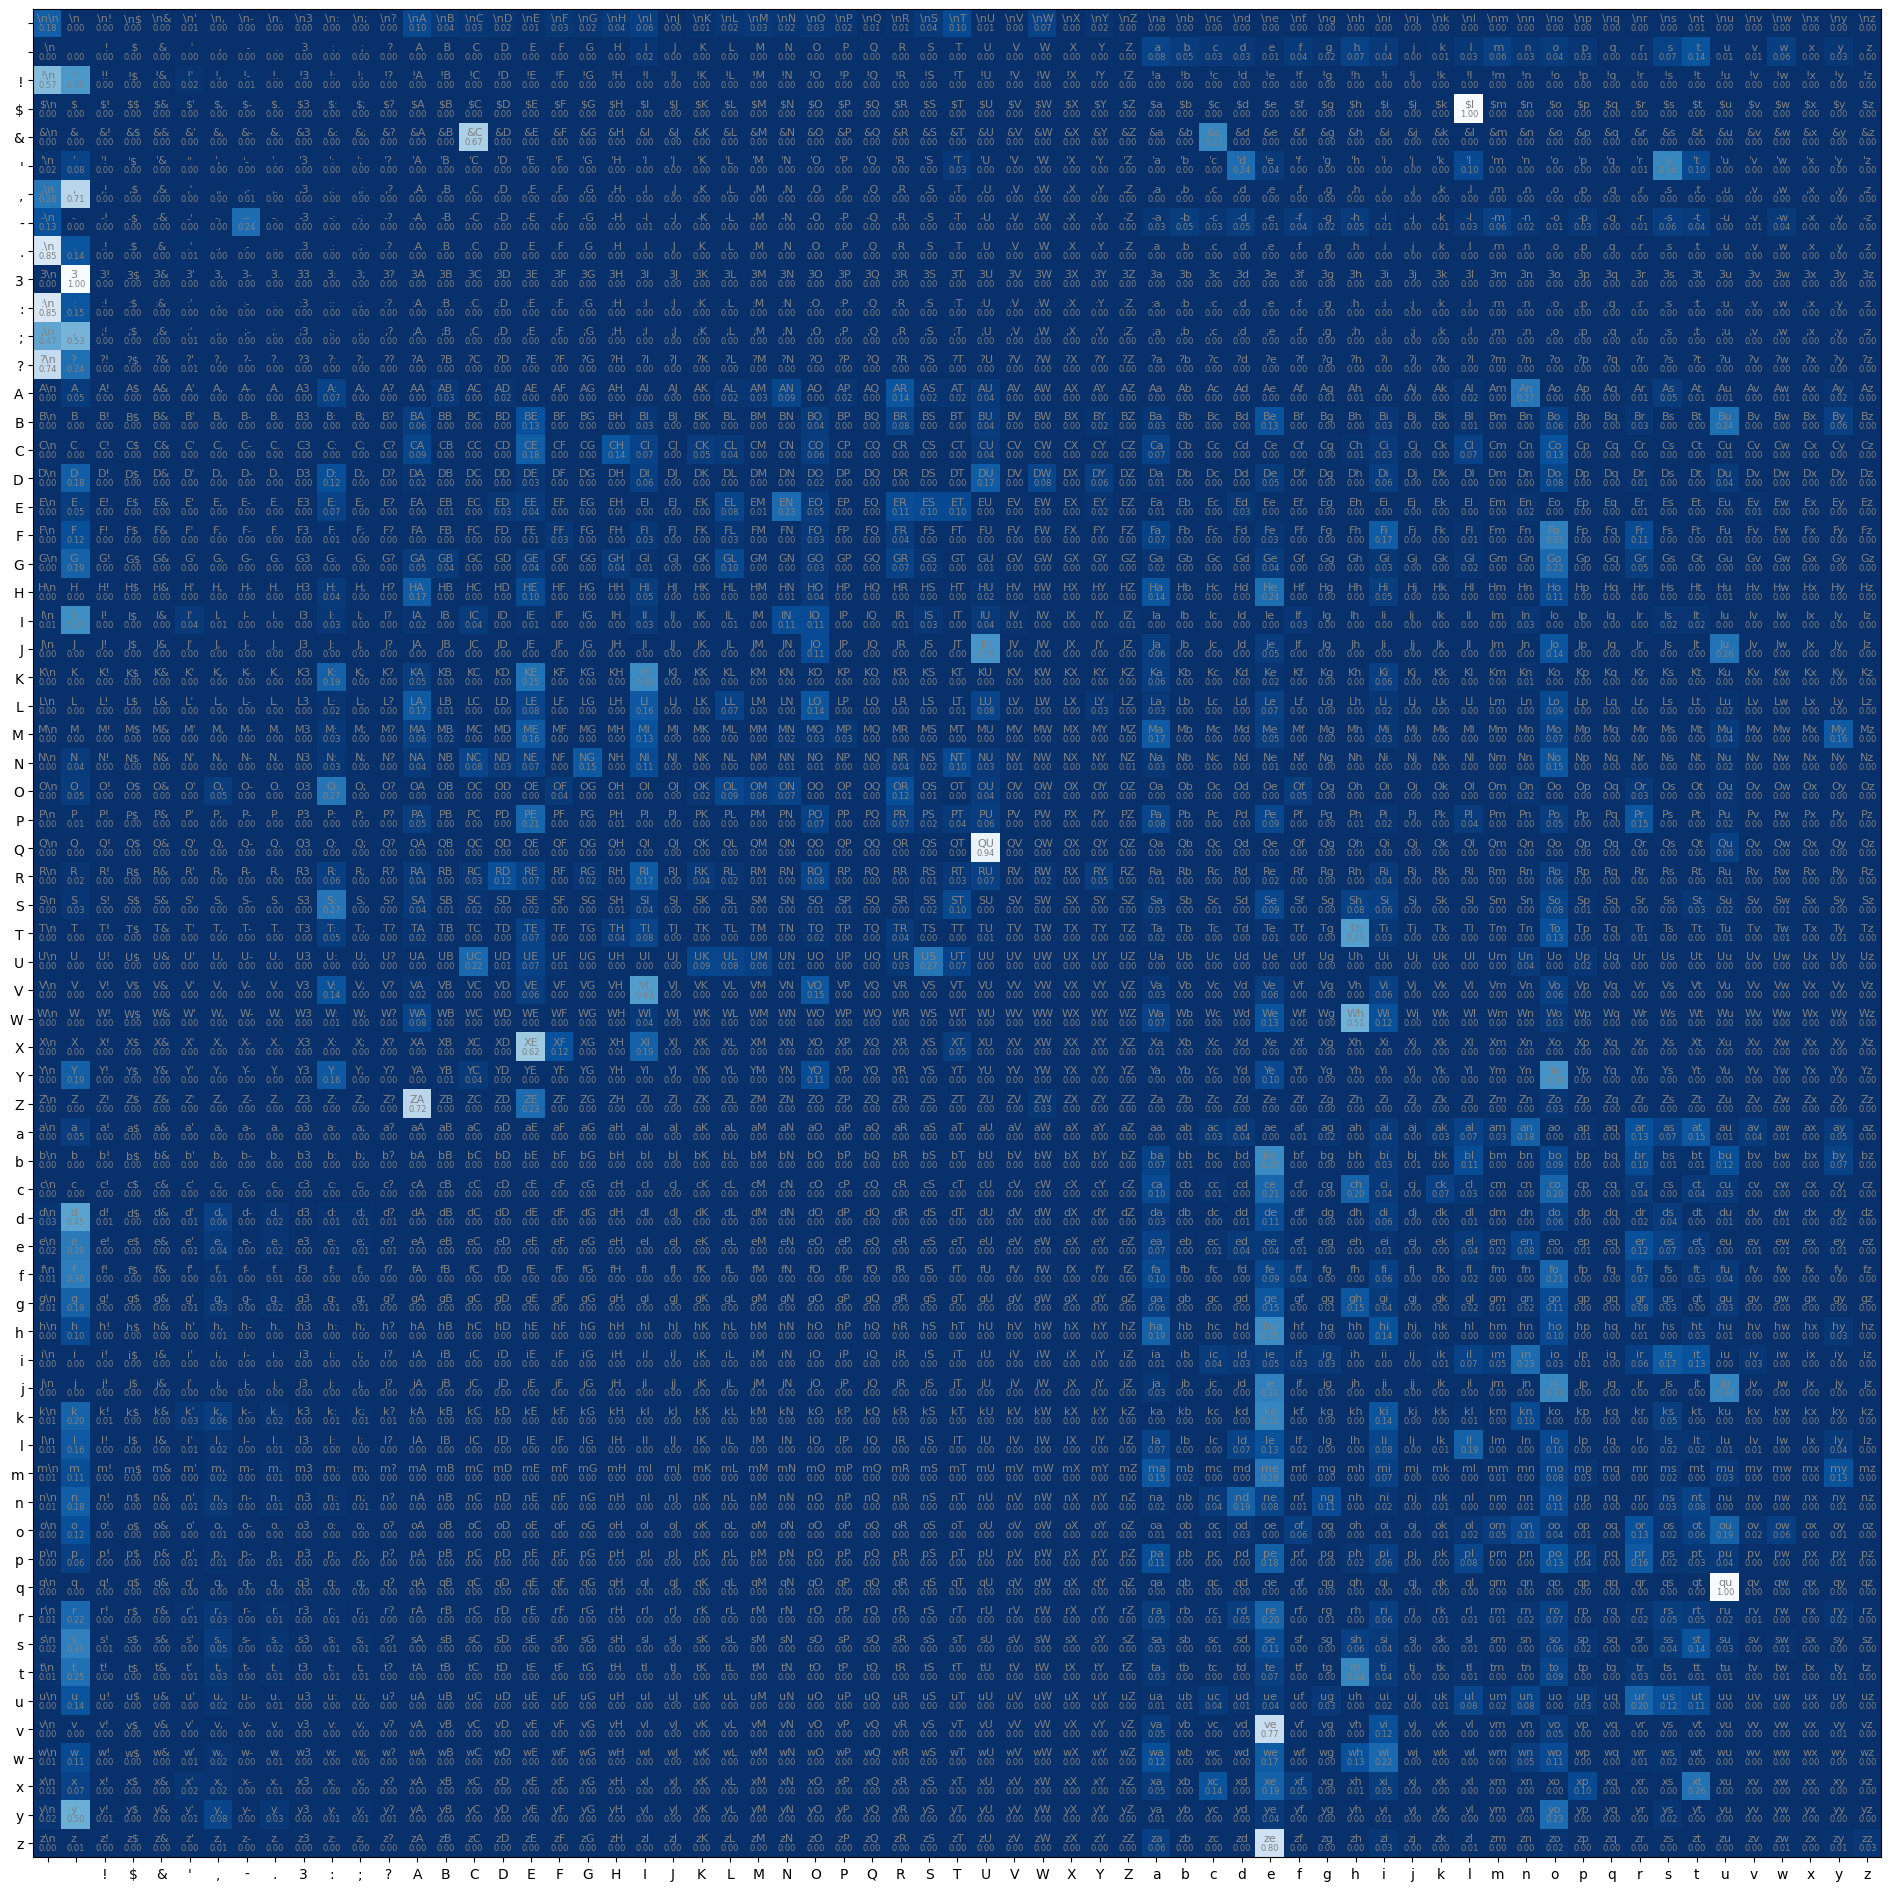

In [ ]:
# Plot the bigram
fig, ax = plt.subplots(1, 1, figsize=(24, 24))
im = ax.imshow(bigram, cmap='Blues_r', interpolation='none', vmin=0, vmax=1)


for i in range(vocab_size):
    for j in range(vocab_size):
        seq = f'{repr(itos[i])[1:-1]}{repr(itos[j])[1:-1]}'

        if seq == '$$':
            seq = '\\$\\$' # special case https://github.com/matplotlib/matplotlib/issues/20266/#issuecomment-844462696
        plt.text(j, i, seq, ha='center', va='bottom', color='gray', fontsize=8)
        plt.text(j, i, f'{bigram[i][j].item():.2f}', ha='center', va='top', color='gray', fontsize=6)


ax.set_xticks(range(vocab_size))
ax.set_xticklabels(chars)
ax.set_yticks(range(vocab_size))
_ = ax.set_yticklabels(chars)



# Compare progress through blocks to bigram

In [ ]:
def plot_block_intermediate_probs(s: str):
    intermediates = get_block_intermediates(s)

    nblocks = len(intermediates)
    nitems = len(intermediates[0])

    fig = plt.figure(figsize=(24, 24))

    nrows = nblocks + 1 # +1 for the bigram row
    ncols = nitems

    x_indices = np.arange(vocab_size)
    x_labels = [repr(c)[1:-1] for c in chars]

    # Add the bigram row
    ax = fig.add_subplot(nrows, ncols, 1)
    ax.bar(x_indices, bigram[stoi[s[-1]]])
    ax.set_xticks(x_indices, x_labels, rotation='vertical')
    ax.set_title('bigram')
    ax.set_ylim(0., 1.)

    titles = ['input', 'self attention output', 'ffwd output', 'block output']
    for b in range(1, nrows):
        for i in range(nitems):
            ax = fig.add_subplot(nrows, ncols, (b*ncols)+i+1)

            p = probs(intermediates[b-1][i])[0]
            ax.bar(x_indices, p.numpy())
            ax.set_xticks(x_indices, x_labels, rotation='vertical', fontsize=8)
            ax.set_title(titles[i])
            ax.set_ylim(0., 1.)

    plt.tight_layout()



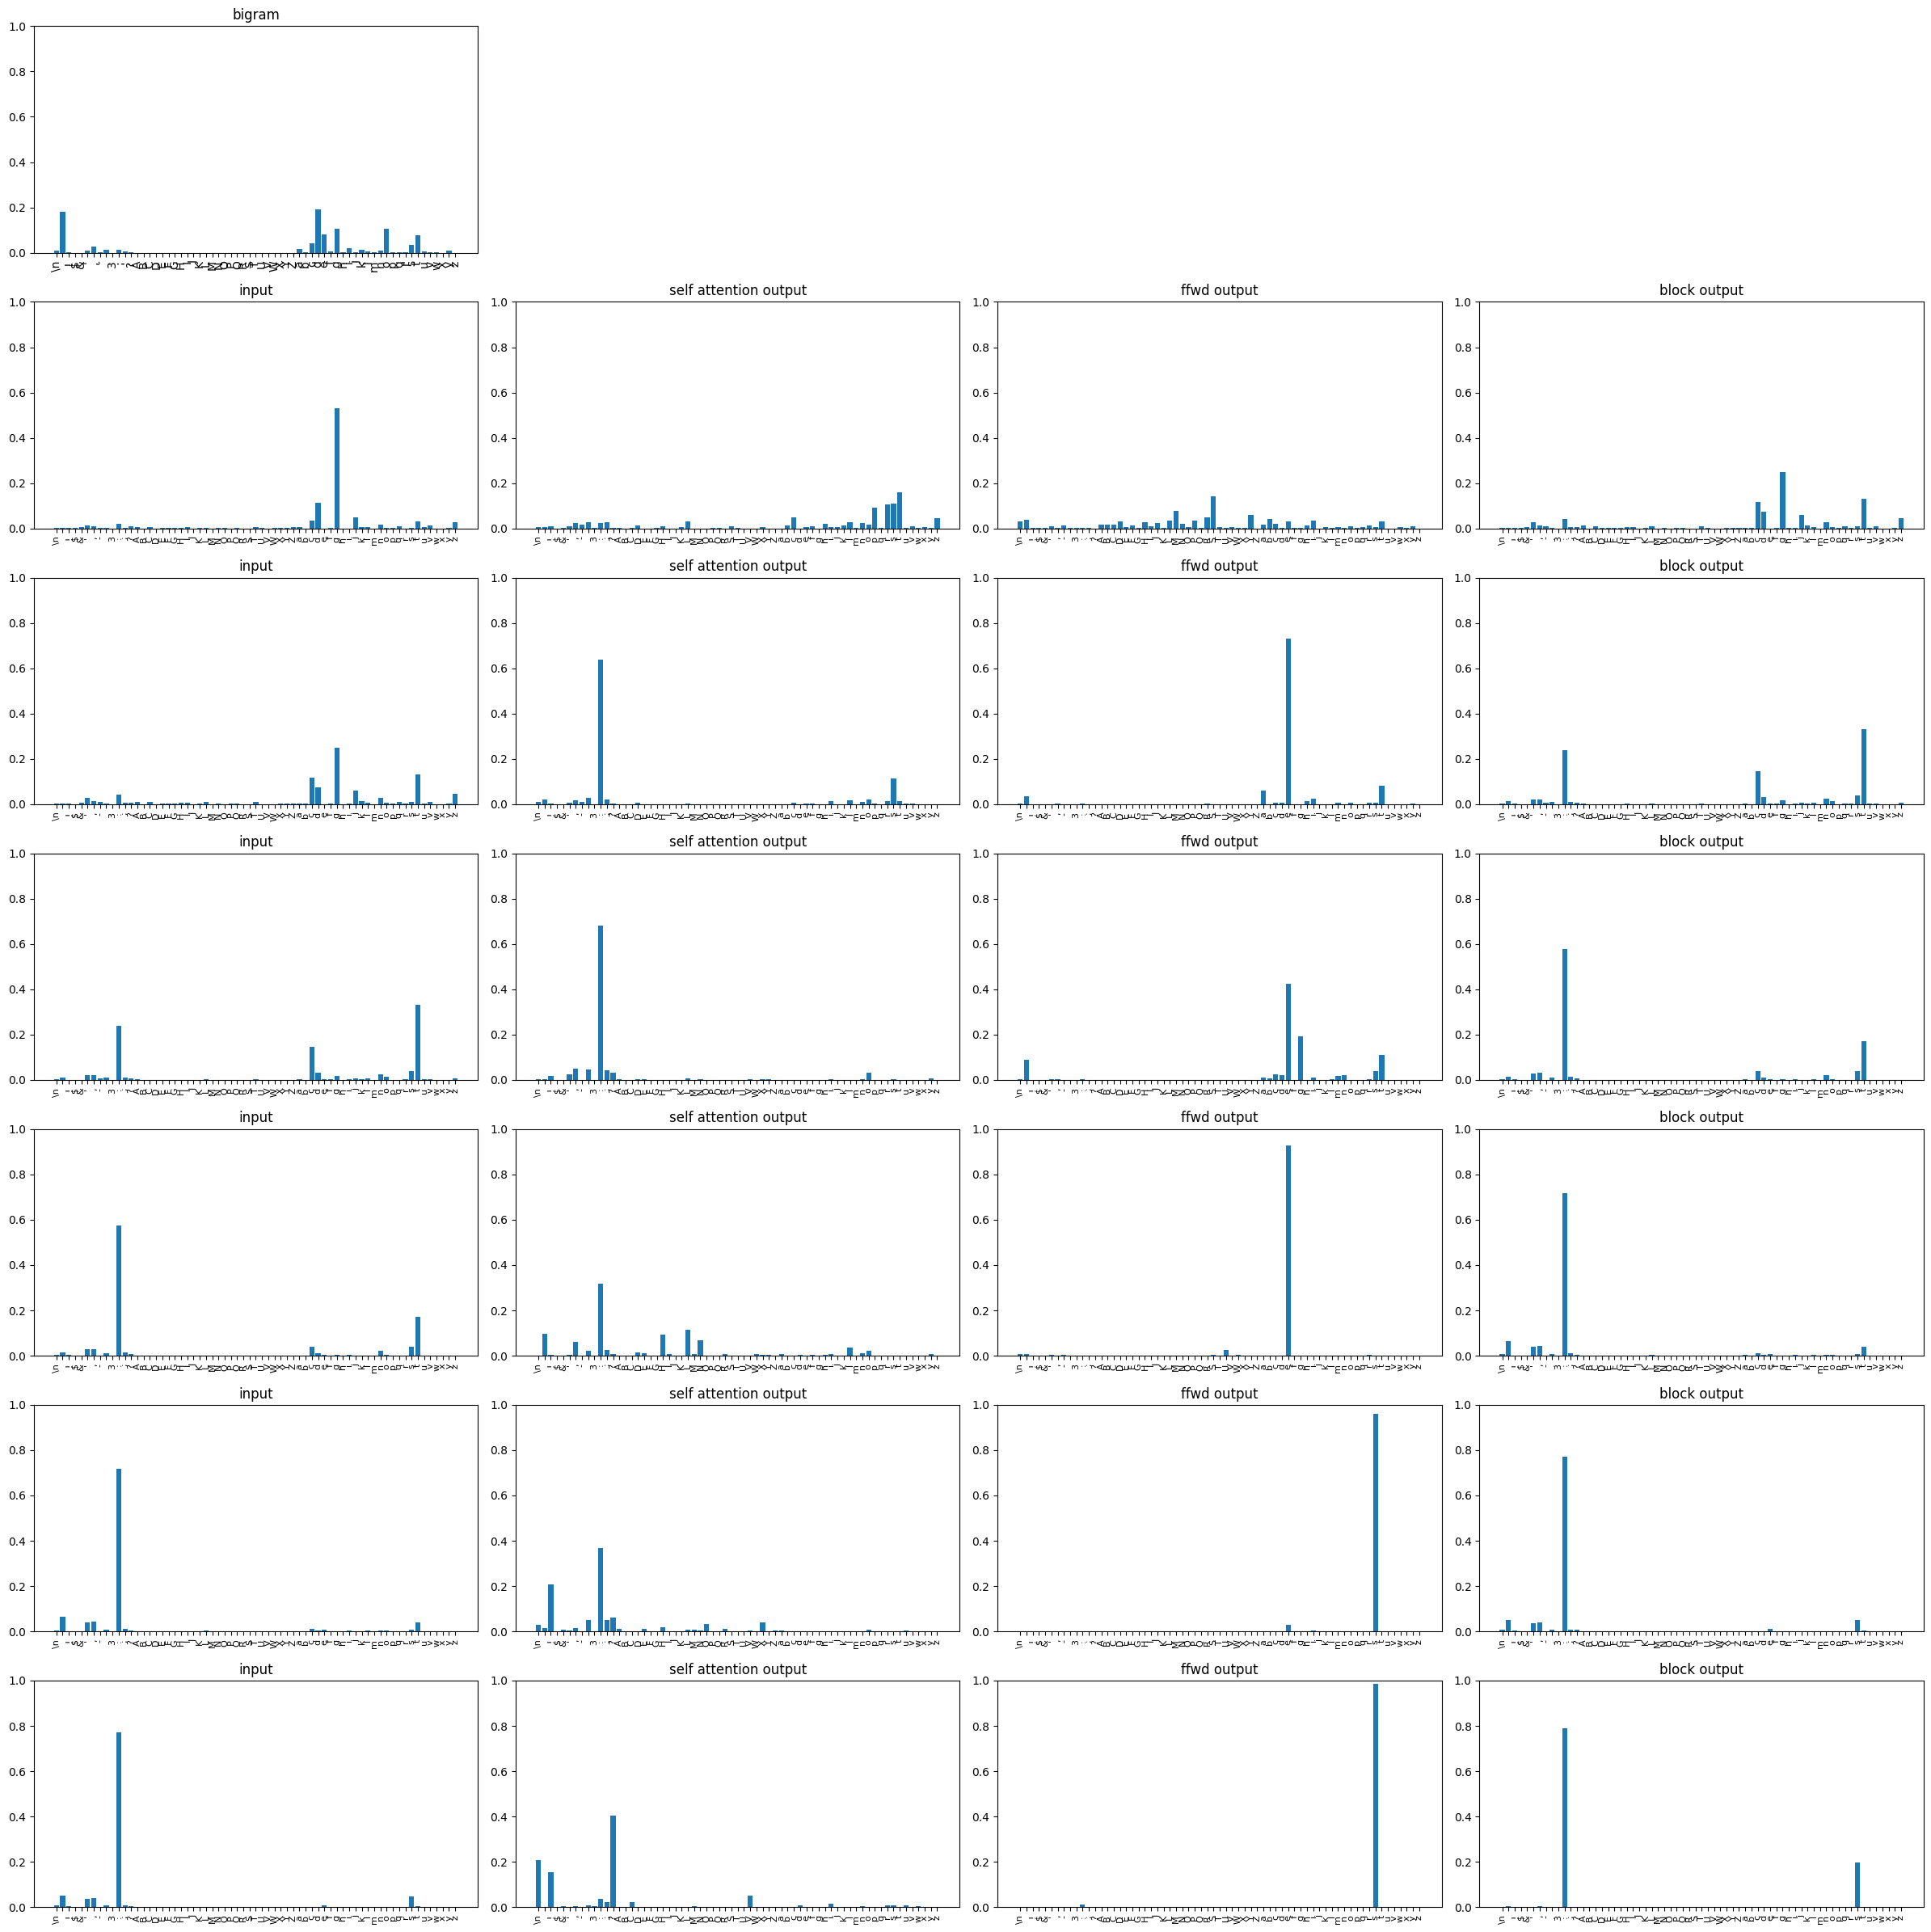

In [ ]:
plot_block_intermediate_probs('Citizen')

## Isolate the Effects of Each Head
Based on the diagram above, block index 1's self attention output looks a lot like the final output. 

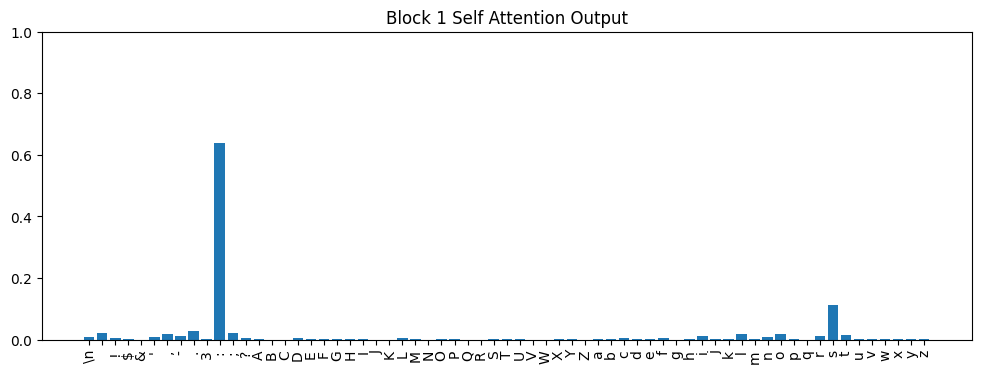

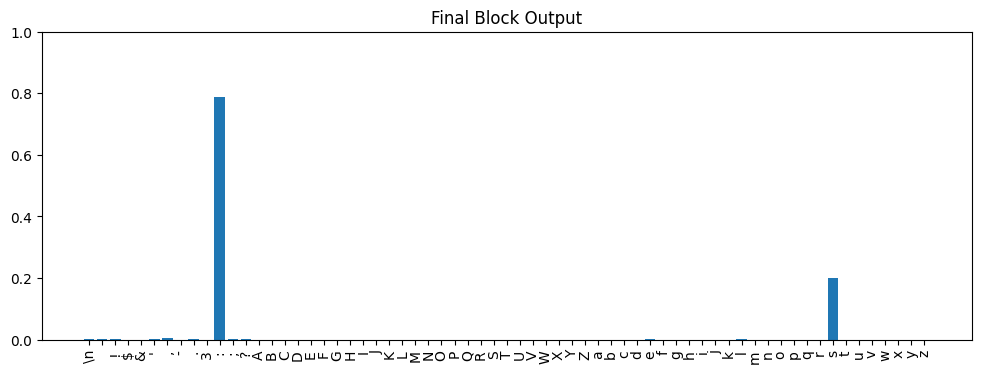

In [ ]:
intermediates = get_block_intermediates('Citizen')
block1_sa = intermediates[1][1]
final_block_output = intermediates[-1][-1]

plot_probs(probs(block1_sa)[0], title="Block 1 Self Attention Output")
plot_probs(probs(final_block_output)[0], title="Final Block Output")


Let's look how how each head contributes to the calculation.

In [ ]:
def head_progression(s: str, block_idx: int):
    assert block_idx < n_layer

    x = encode_input(s)

    # Run the input through all the blocks before block_idx
    for i in range(block_idx):
        x = m.blocks[i](x)

    results = []
    # Start with all but head 0 disabled and progressively disable
    # one less head each iteration until we run the block with no
    # heads disabled
    for disabled_start_idx in range(1, n_head + 1):
        disable_heads = range(disabled_start_idx, n_head)

        block, io_accessor = copy_block_from_model_and_disable_heads(
            block_idx, disable_heads
        )
        _ = block(x)

        results.append(((disable_heads), io_accessor.output('sa')))
    return results


def title_from_disabled_heads(disabled_heads: Iterable[int]):
    enabled_heads = [i for i in range(n_head) if i not in disabled_heads]

    enabled_str = (
        ', '.join([f'h{i}' for i in enabled_heads])
        if len(enabled_heads) > 0
        else 'none'
    )
    disabled_str = (
        ', '.join([f'h{i}' for i in disabled_heads])
        if len(disabled_heads) > 0
        else 'none'
    )

    return f"{enabled_str} enabled; {disabled_str} disabled"

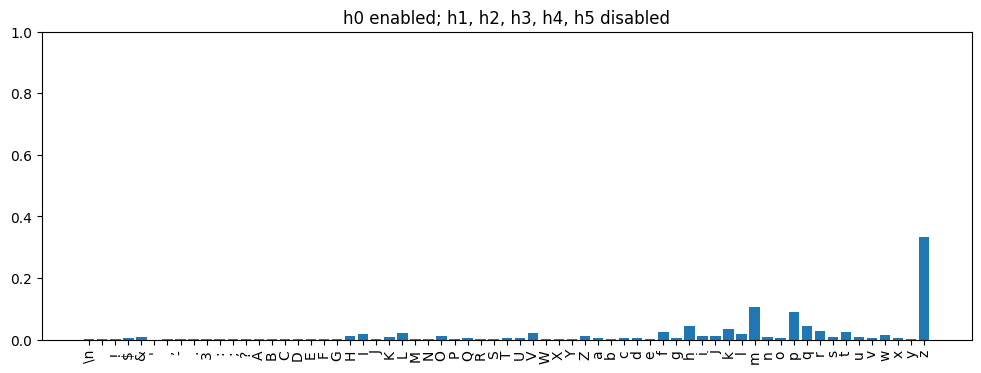

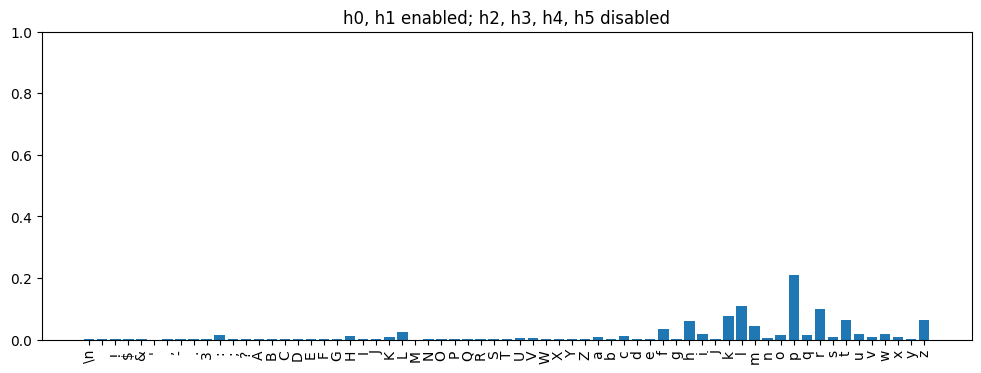

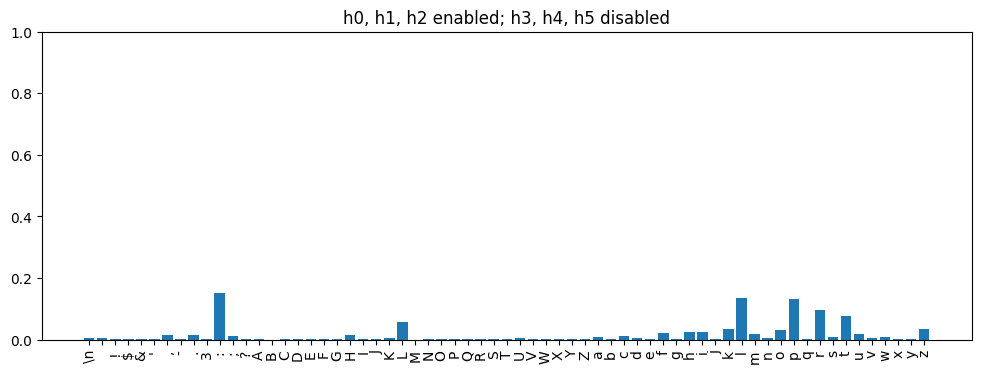

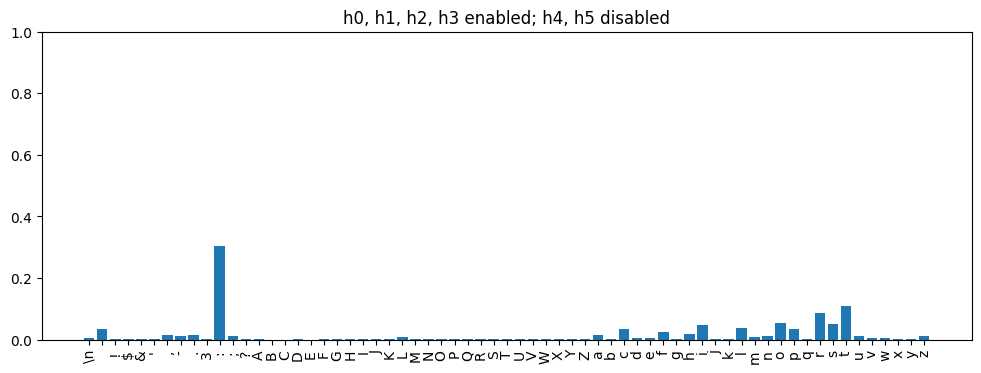

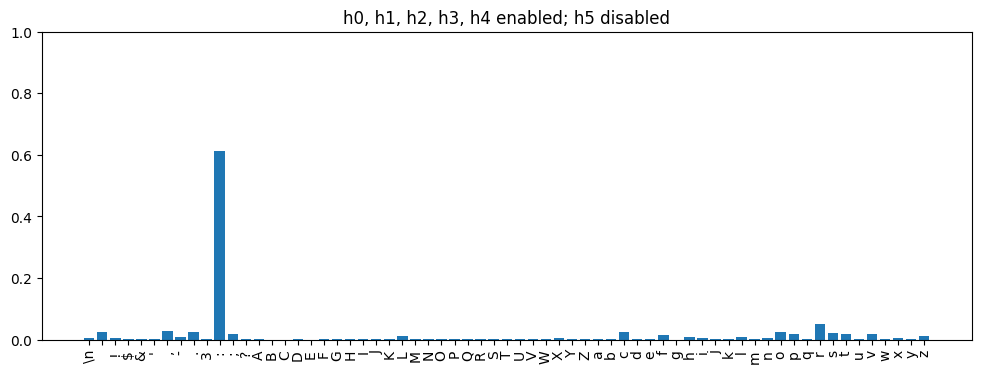

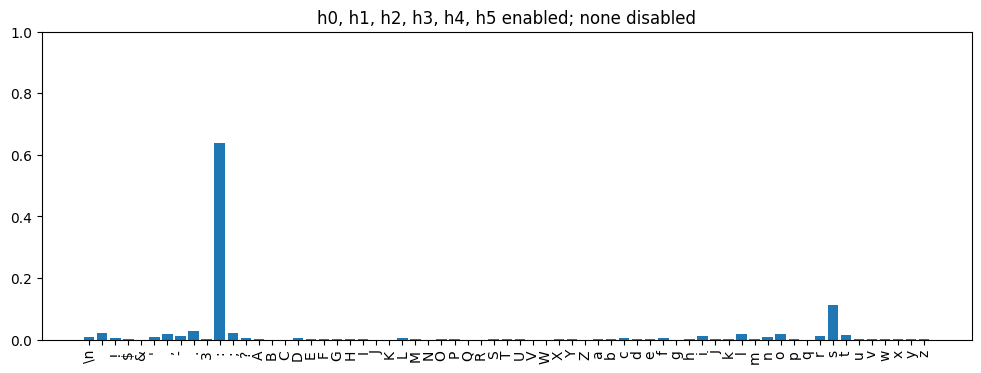

In [ ]:
h_prog = head_progression('Citizen', block_idx=1)
for disabled_heads, out in h_prog:
    plot_probs(probs(out)[0], title=title_from_disabled_heads(disabled_heads))

## Learn Final Embeddings for Tokens

In [ ]:
def learn_embedding_for_char(
    target_char: str, 
    ln_f_state_dict: Dict[str, Any],
    lm_head_state_dict: Dict[str, Any],
    learning_rate: float = 3e-4,
    max_iters: int = 50000,
    device: str = device,
) -> torch.Tensor:
    """Given a character, learns the embedding that,
    when given as input to the `ln_f` layer norm layer and 
    then the `lm_head` linear layer at
    the end of the transformer, produces the logits select
    that character with probability almost 1."""
    assert len(target_char) == 1
    target = torch.tensor(encode(target_char)[0], device=device)

    # Create the ln_f and lm_head layers with the models weights and biases.
    ln_f = nn.LayerNorm(n_embed)
    lm_head = nn.Linear(n_embed, vocab_size)

    ln_f.load_state_dict(ln_f_state_dict)
    lm_head.load_state_dict(lm_head_state_dict)

    ln_f.to(device)
    lm_head.to(device)

    lsfm = nn.LogSoftmax(dim=-1)
    lsfm.to(device)

    x = torch.nn.Parameter(torch.randn(n_embed), requires_grad=True).to(device)

    optimizer = torch.optim.AdamW([x], lr=learning_rate)
    eval_iters = max_iters // 10  

    print(f"Optimizing embedding for {repr(target_char)}")
    for step in range(max_iters):
        yhat = lsfm(lm_head(ln_f(x)))
        loss = F.nll_loss(yhat, target)

        if torch.isclose(loss, torch.tensor(0, dtype=loss.dtype, device=device)).item():
            print(f"ending training at step {step}: loss {loss.item():.4f}")
            break 

        if step % eval_iters == 0:
            print(f"step {step}: loss {loss.item():.4f}")

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return x.data.detach(), loss

def unsq_emb(emb: torch.Tensor) -> torch.Tensor:
    """Helper function that takes a 1-D embedding vector (shape C) and unsqueezes it
    into the B, T, C shape that most other functions expect.""" 
    return emb.unsqueeze(dim=0).unsqueeze(dim=0)


In [ ]:
# Test it
test_char = 's'
emb, _ = learn_embedding_for_char(test_char, m.ln_f.state_dict(), m.lm_head.state_dict())
top_chars = topk_chars(unsq_emb(emb), k=3)

print("\n")
print("Top chars for learned embedding:")
for char, prob in top_chars:
    print(f"{repr(char)}: probability {prob:.2f}")

top1_char, _ = top_chars[0]
test_eq(top1_char, test_char)

Optimizing embedding for 's'
step 0: loss 4.7443
step 5000: loss 0.0077
step 10000: loss 0.0006
step 15000: loss 0.0000
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 26547: loss 0.0000
Top chars for learned embedding:
's': probability 1.00
'n': probability 0.00
'm': probability 0.00


In [ ]:
# Create a dictionary of the embeddings learned for each character
char_to_embedding = {
    c: learn_embedding_for_char(
        target_char=c,
        ln_f_state_dict=m.ln_f.state_dict(), 
        lm_head_state_dict=m.lm_head.state_dict(),
    )[0]
    for c in chars
}

In [ ]:
# Save char to embedding as json file
c2e_list = {
    c: embed.tolist()
    for c, embed in char_to_embedding.items()
}
Path('./char_to_embed.json').write_text(json.dumps(c2e_list, indent=2))

In [ ]:
# Load char to embedding from json file

c2e_json = json.loads(Path('./char_to_embed.json').read_text())
c2e_loaded = {
    c: torch.tensor(emb_list, dtype=torch.float32, device=device)
    for c, emb_list in c2e_json.items()
}

In [ ]:
char_to_embedding = c2e_loaded

## Examine Final Embeddings

In [ ]:
def plot_emb(emb: torch.Tensor, title: str=''): 
    """Wrapper function to plot embeddings with less typing."""
    plot_probs(probs(unsq_emb(emb))[0], title=title)

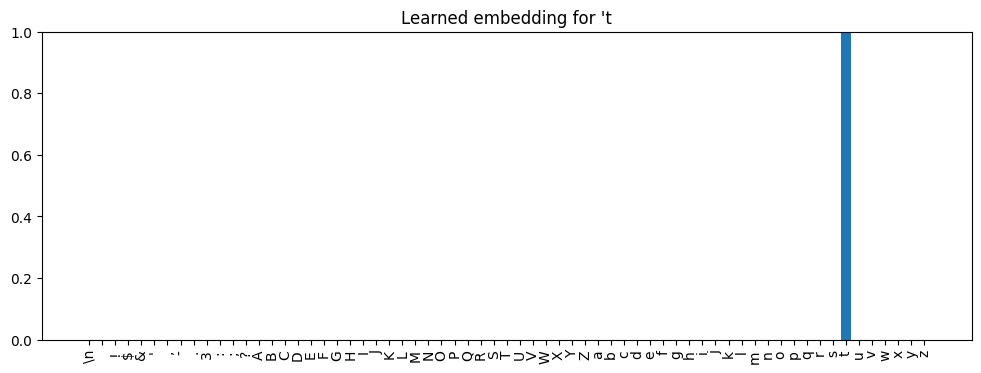

In [ ]:
# Show that a given embedding produces the expected probability distribution:
plot_emb(char_to_embedding['t'], title="Learned embedding for 't")

But, the learned embedding is not unique! For one thing, we can scale it and still get the same output probability distribution.

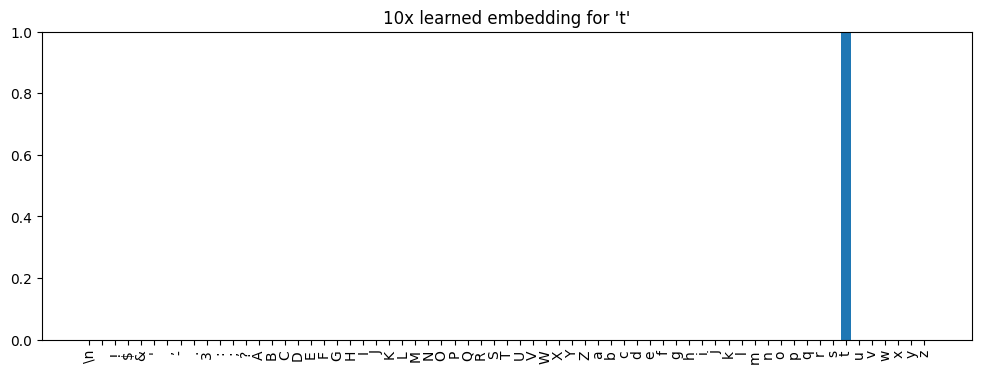

In [ ]:
plot_emb(10*char_to_embedding['t'], title="10x learned embedding for 't'")

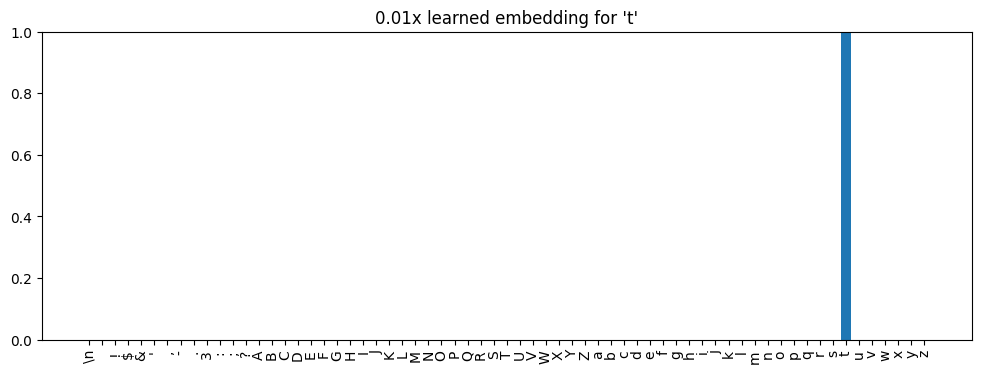

In [ ]:
plot_emb(0.01*char_to_embedding['t'], title="0.01x learned embedding for 't'")

But also, subsequent learning runs might well learn a different embedding for the same char.

In [ ]:
test_char = 't'
emb1, _ = learn_embedding_for_char(test_char, m.ln_f.state_dict(), m.lm_head.state_dict())
emb2, _ = learn_embedding_for_char(test_char, m.ln_f.state_dict(), m.lm_head.state_dict())



Optimizing embedding for 't'
step 0: loss 3.6702
step 5000: loss 0.0075
step 10000: loss 0.0006
step 15000: loss 0.0000
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 28181: loss 0.0000
Optimizing embedding for 't'
step 0: loss 5.2826
step 5000: loss 0.0067
step 10000: loss 0.0005
step 15000: loss 0.0000
step 20000: loss 0.0000
step 25000: loss 0.0000
ending training at step 28293: loss 0.0000


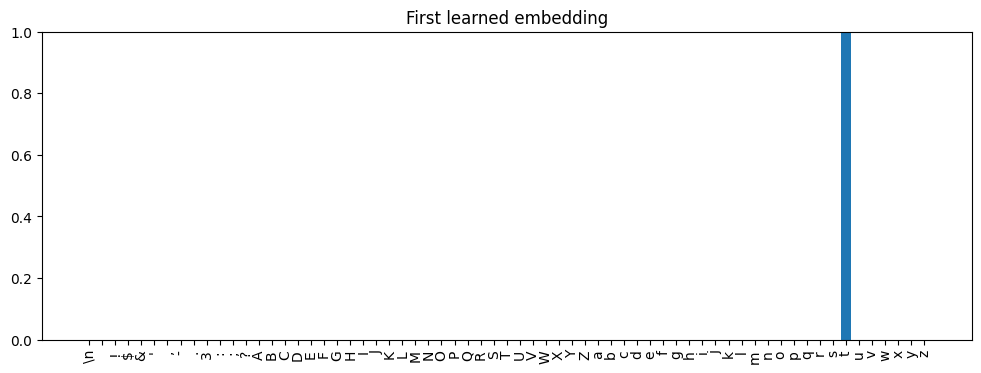

In [ ]:
plot_emb(emb1, title="First learned embedding")

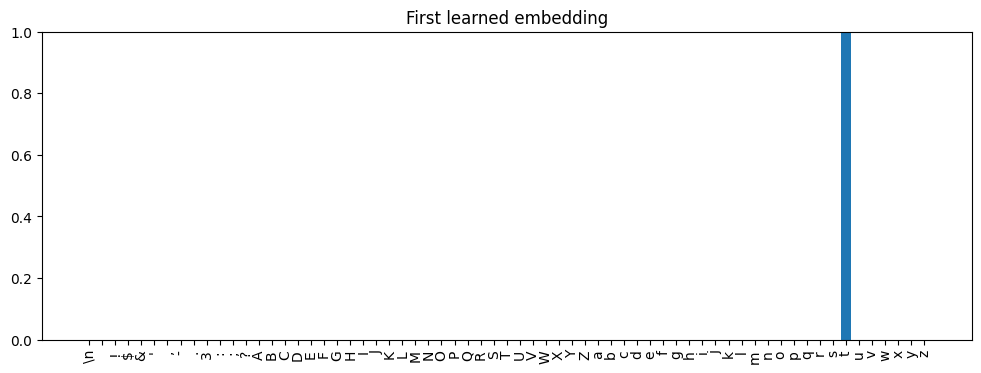

In [ ]:
plot_emb(emb2, title="First learned embedding")

OK, so they both produce the same (expected probability distribution). But they are different:
* in the values in the tensors
* in magnitude
* in direction

In [ ]:
print(f"emb1 == emb2: {all(emb1 == emb2)}")
print(f"emb1 close to emb2: {all(torch.isclose(emb1, emb2))}")
print(f"magnitude of emb1: {torch.norm(emb1):.3f}, magnitude of emb2: {torch.norm(emb2):.3f}")
print(f"cosine similarity of emb1 and emb2: {F.cosine_similarity(emb1, emb2, dim=-1):.3f}")


emb1 == emb2: False
emb1 close to emb2: False
magnitude of emb1: 16.823, magnitude of emb2: 15.234
cosine similarity of emb1 and emb2: 0.630


This suggests that there isn't a single unique embedding vector for each token but rather a sub-space. Any vector in this sub-space will produce the same output probability distribution. Let's try to explore that space. 

## Rotating Embedding Vectors

TODO: insert some math about the subspace

The math is a bit gnarly, so let's do a simpler brute force approach. Rotate the vectors in each plane and see what happens.

In [ ]:
"""Functions to convert between cartesian and spherical coordinates.
"""


def spherical_from_cartesian(emb: torch.Tensor, n_embed: int = n_embed):
    # Expect `emb` to be a 1-D tensor of length n_embed
    sz = emb.shape
    assert len(sz) == 1
    assert sz[0] == n_embed

    r = torch.norm(emb)
    phis = torch.zeros(n_embed - 1, dtype=emb.dtype)

    # Per https://en.wikipedia.org/wiki/N-sphere

    # Calculate phis[0] through phis[n_embed-2]
    for i in range(n_embed - 1):
        phis[i] = torch.arccos(emb[i] / torch.sqrt(torch.sum(emb[i:n_embed] ** 2))).item()

    # Calculate phis[n_embed-1]
    if emb[-1] >= 0:
        phis[i] = torch.arccos(emb[-2] / torch.sqrt(emb[-1] ** 2 + emb[-2] ** 2)).item()
    else:
        phis[i] = 2 * torch.pi - torch.arccos(
            emb[-2] / torch.sqrt(emb[-1] ** 2 + emb[-2] ** 2)
        ).item()

    # Special cases
    for i in range(n_embed - 1):
        if emb[i] == 0:
            continue

        if torch.count_nonzero(emb[i + 1 : n_embed]) == 0:
            phis[i] = 0 if emb[i] > 0 else torch.pi

    return r.item(), phis


def cartesian_from_spherical(r: float, angles: torch.Tensor, n_embed: int = n_embed):
    sz = angles.shape
    assert len(sz) == 1
    assert sz[0] == n_embed - 1

    emb = torch.zeros(n_embed, dtype=angles.dtype)

    # Per https://en.wikipedia.org/wiki/N-sphere

    # Cache sin and cos of all angles
    sines = torch.sin(angles)
    coses = torch.cos(angles)

    # To compute x_n we have to compute
    # sin(phi_0) * sin(phi_1) * ... * sin(phi_n-1)
    # 
    # Rather than computing product once for each x_n, we pre-compute the
    # cumulative product of all the sines. But we stick a 1 in the front of
    # all the sines so that the indices are all offset by one without changing
    # the values of the cumulative products. This way, when computing x_i, we 
    # can just multiply by sin_cumulative_products[i] and this works even for
    # x_0 (which does not get multiplied by any sines). 
    sin_cumulative_products = torch.cumprod(torch.cat((torch.tensor([1]), sines)), dim=-1)

    # Compute emb[0:n_embed-1]
    for i in range(n_embed - 1):
        emb[i] = (r * sin_cumulative_products[i] * coses[i]).item()

    # Compute emb[n_embed-1]
    emb[n_embed - 1] = (r * sin_cumulative_products[n_embed - 1]).item()

    return emb

In [ ]:
# Tests for spherical_from_cartesian

# A 2-D [1, 1] vector which should have magnitude sqrt(2) and a 45 degree angle
r, phis = spherical_from_cartesian(torch.tensor([1., 1.]), n_embed=2)
test_close(r, math.sqrt(2))
test_close([torch.rad2deg(phi).item() for phi in phis], [45.])

# A 3-D [1, 1, 1] vector. Magnitude is sqrt(3), angle in one plane is 45, other
# is arccos(1/sqrt(3)).
r, phis = spherical_from_cartesian(torch.tensor([1., 1., 1.]), n_embed=3)
test_close(r, math.sqrt(3))
test_close(
    [torch.rad2deg(phi).item() for phi in phis],
    [math.degrees(math.acos(1/math.sqrt(3))), 45.]
)

# A 3-D [1, 1, 0] vector. Magnitude is sqrt(2), angle in one plane is 45, other
# is 0.
r, phis = spherical_from_cartesian(torch.tensor([1., 1., 0.]), n_embed=3)
test_close(r, math.sqrt(2))
test_close(
    [torch.rad2deg(phi).item() for phi in phis],
    [45., 0.]
)


In [ ]:
# Tests for cartesian_from_spherical

emb = char_to_embedding['c'] # Grab an embedding
r, phis = spherical_from_cartesian(emb) # Convert to spherical
emb2 = cartesian_from_spherical(r, phis) # Convert back to Cartesian

# Original and the one we roundtripped should be close
test_close(emb, emb2)

In [ ]:
def perform_rotations(char: str, char_to_embedding: Dict[str, torch.Tensor], n_steps=6):
    emb = char_to_embedding[char]
    r, phis = spherical_from_cartesian(emb)

    n_phi = phis.size()[0]

    results = np.zeros((n_phi, n_steps), dtype=np.float32)

    for i in tqdm(range(n_phi)):
        angle_range = torch.pi if i != n_phi - 1 else 2*torch.pi
        step_size = angle_range / (n_steps-1)
        angle = 0
        for j in range(n_steps):
            angle = j*step_size

            phis_copy = phis.clone()
            phis_copy[i] = angle
            emb_new = cartesian_from_spherical(r, phis_copy)
            top_chars = topk_chars(unsq_emb(emb_new), k=5)

            for c, p in top_chars:
                if c == char:
                    results[i][j] = p
    return results


In [ ]:
# Define names for special characters that can be used as filenames.
special_char_names = {
    '\n': 'newline',
    ' ': 'space',
    '!': 'exclamation',
    '$': 'dollar',
    '&': 'ampersand',
    '\'': 'single_quote',
    ',': 'comma',
    '-': 'dash',
    ':': 'colon',
    ';': 'semicolon',
    '.': 'period',
    '?': 'question',    
}

In [ ]:
# Run the rotations process across all the characters and write the output to files
for c in chars:
    print(f"Performing rotations for {repr(c)}")
    results = perform_rotations(c, char_to_embedding, n_steps=100)
    filename = special_char_names.get(c, c)

    Path(f'./rotations/{filename}.json').write_text(json.dumps(results.tolist(), indent=2))
    print(f"Wrote '{filename}.json'")

In [ ]:
def load_rotation_results(char: str) -> np.ndarray:
    file = Path(f'./rotations/{special_char_names.get(char, char)}.json')
    return np.array(json.loads(file.read_text()))

In [ ]:
def plot_rotation_results(char: str, n_steps=100):
    results = load_rotation_results(char)
    fig, ax = plt.subplots(1, 1, figsize=(38, 10))
    ax.set_title(f"Rotation results for {repr(char)}", fontsize=26)
    ax.set_xlim(0, n_embed-1)
    ax.set_xticks(range(0, n_embed-1, 16))
    ax.set_ylim(n_steps-1, 0)
    im = ax.imshow(results.T, cmap='viridis', interpolation='none', vmin=0., vmax=1.)


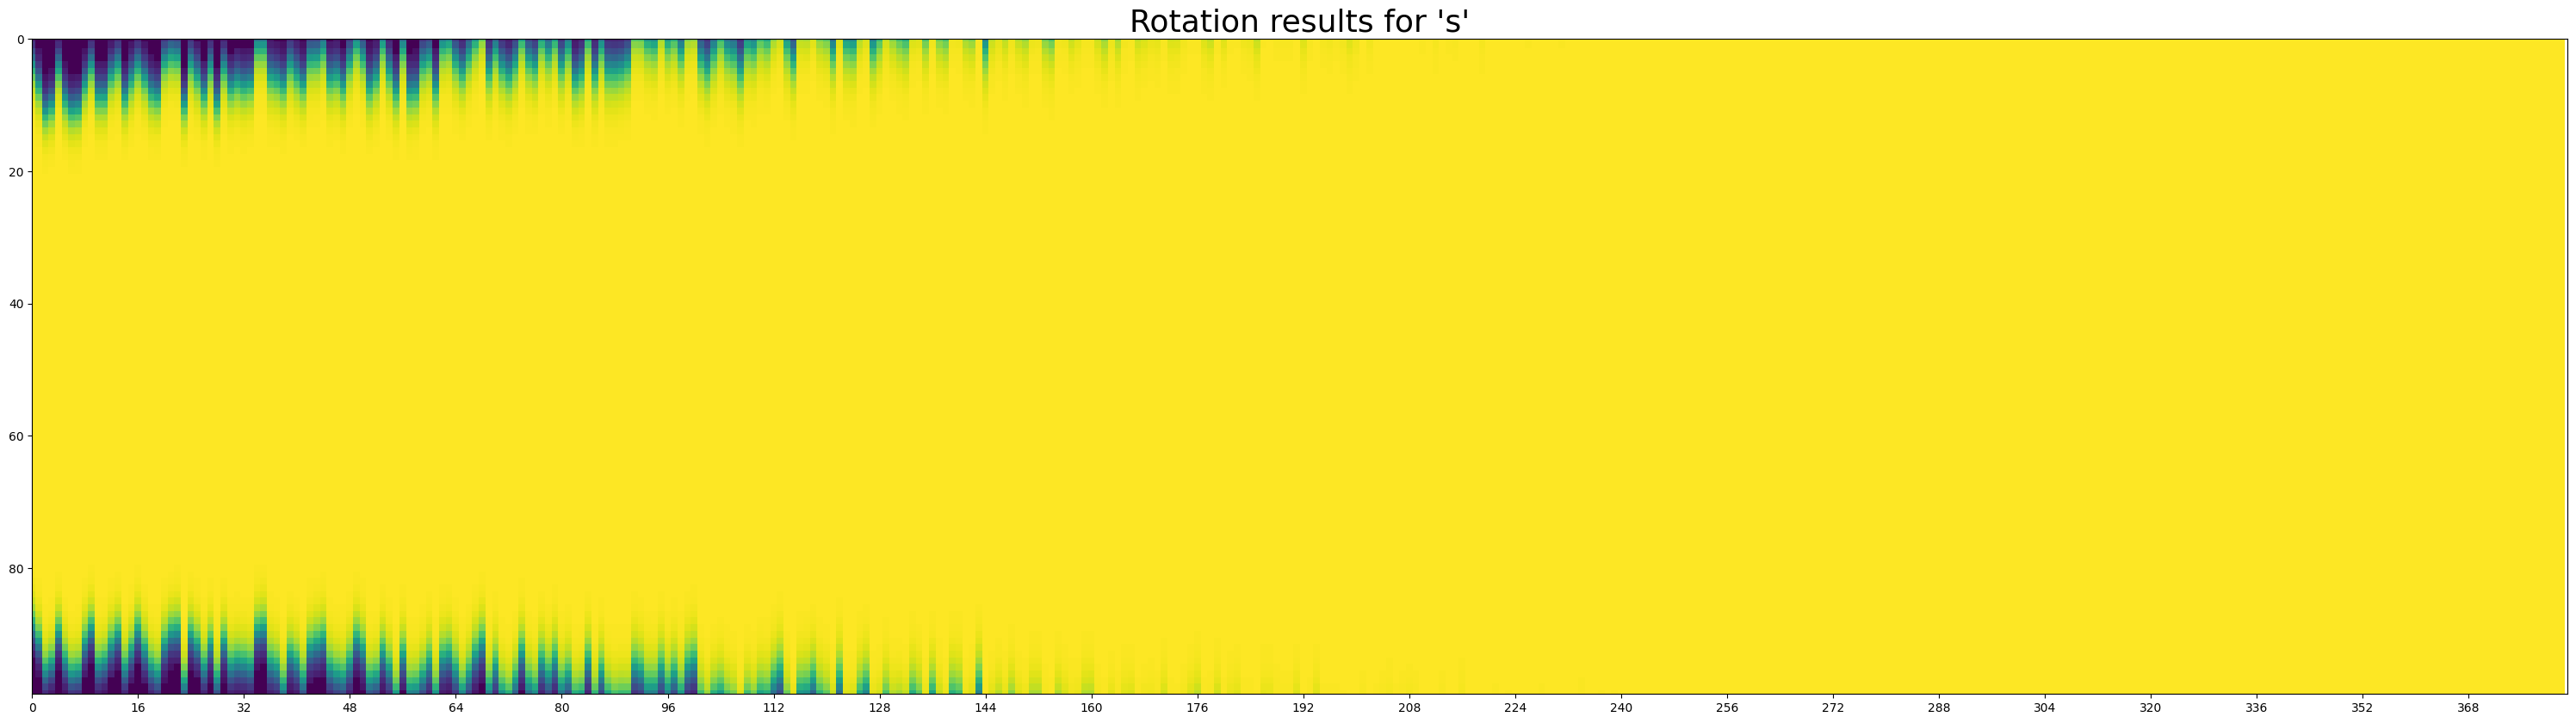

In [ ]:
plot_rotation_results('s')

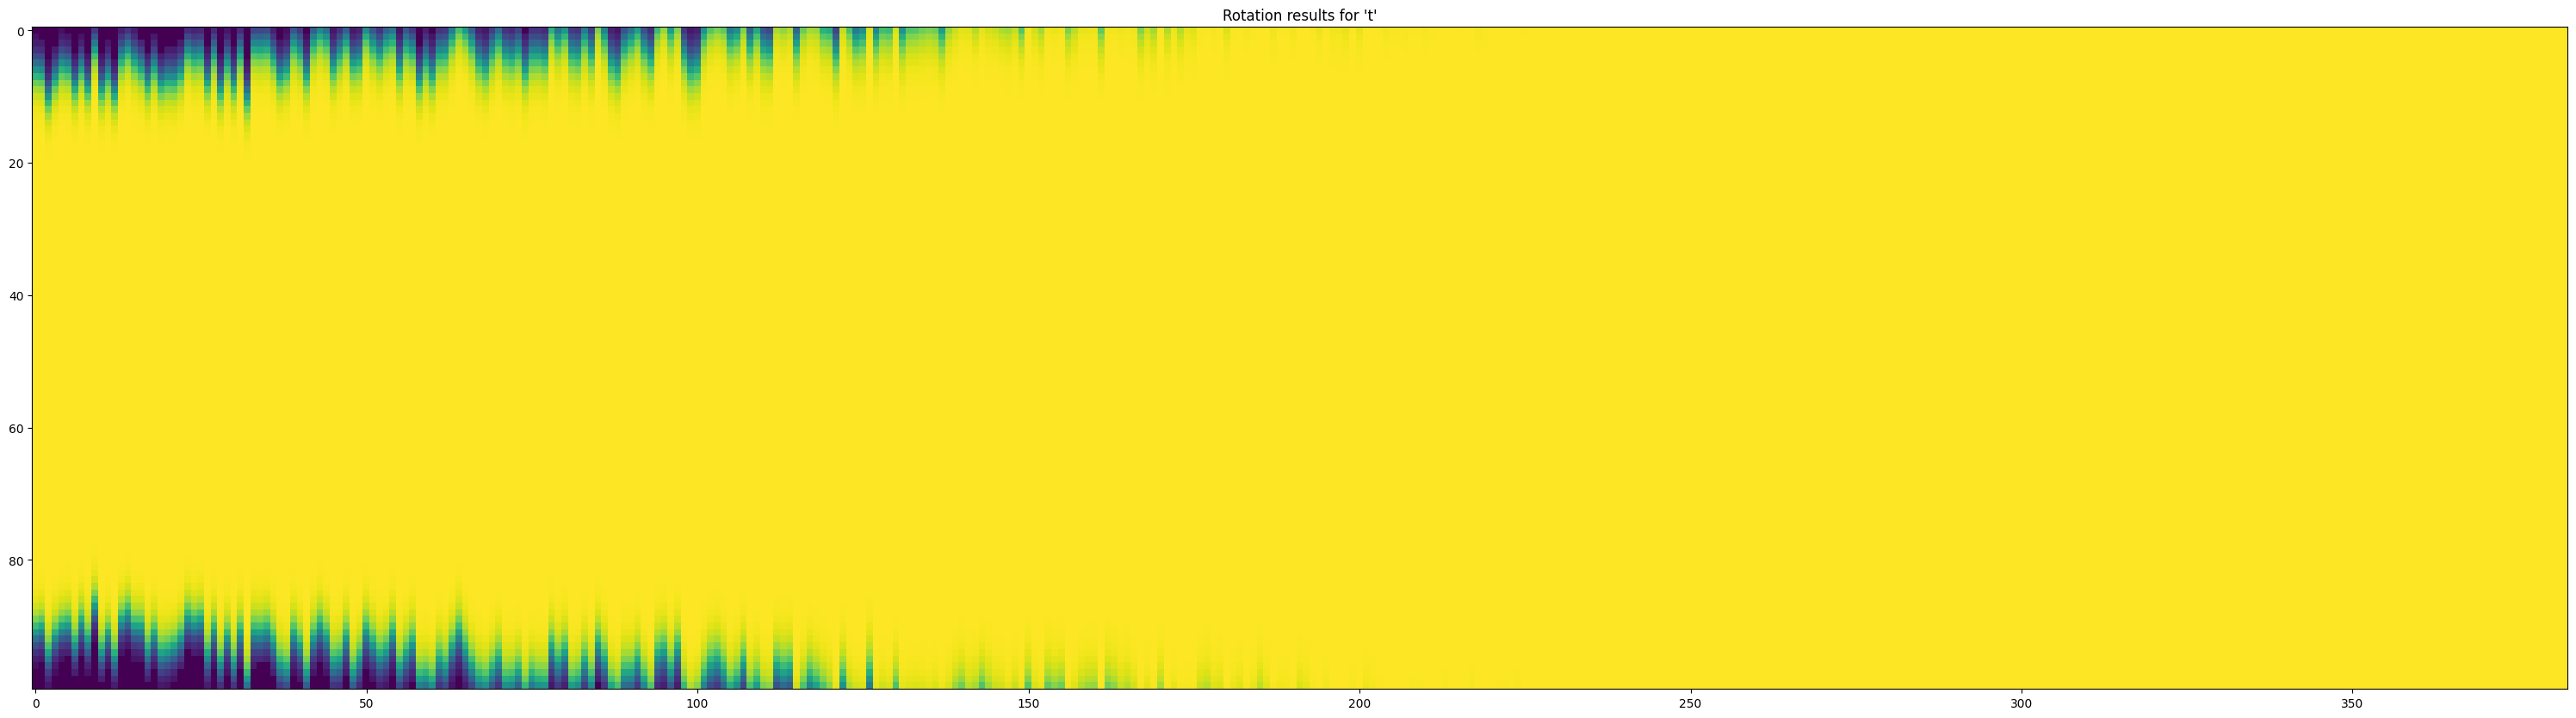

In [ ]:
plot_rotation_results('t')

Takeaways from this: 
* For the last ~180 dimensions, you can rotate it however you like and it makes no difference
* For the earlier dimensions, there is a wide latitude of rotation and only the extremes seem to change the result

In [ ]:
# Quick test to see if we can zero out the last dimensions and have the result stay the same.
emb_t = char_to_embedding['t']
print(topk_chars(unsq_emb(emb_t), k=3))

emb_t_copy = emb_t.clone()
emb_t_copy[95:] = 0
print(topk_chars(unsq_emb(emb_t_copy), k=3))



[('t', 1.0), ('n', 1.9010533591767853e-08), ('d', 1.6493215682089613e-08)]
[('t', 0.9901940226554871), ('p', 0.0020527050364762545), ('g', 0.001365812262520194)]


So I can zero out everything from 95 onwards and still get the target char with 0.99 probability!

In [ ]:
# What about setting the end of the embedding to random values?
emb_t = char_to_embedding['t']
print(topk_chars(unsq_emb(emb_t), k=3))

keep_up_to_idx = 200
rando = torch.randn(len(emb_t) - keep_up_to_idx)
emb_t_copy = torch.cat([emb_t[0:keep_up_to_idx], rando])

test_eq(emb_t[0:keep_up_to_idx], emb_t_copy[0:keep_up_to_idx])
print(topk_chars(unsq_emb(emb_t_copy), k=3))


[('t', 1.0), ('n', 1.9010533591767853e-08), ('d', 1.6493215682089613e-08)]
[('t', 0.9957208037376404), ('p', 0.0005335674504749477), ('T', 0.0003315519425086677)]


This is more sensitive (can only do it from idx ~200 onwards) and it depends on the actual random values.

Note: I'm not scaling the random values so they're probably not representative of the other numbers in the embedding.

## Random Experiments Below

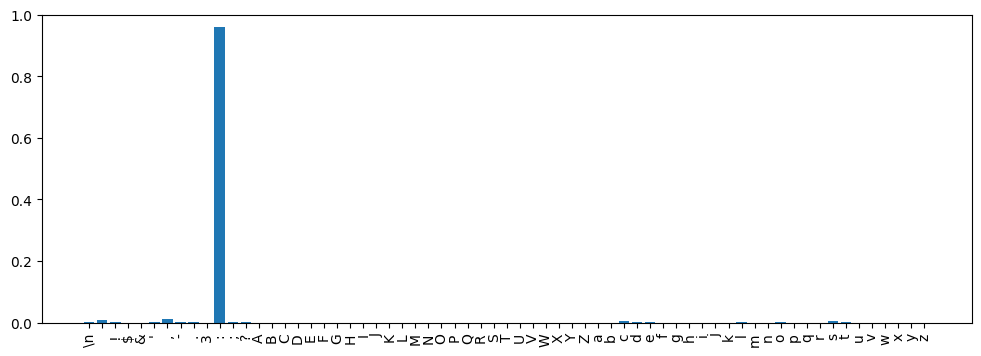

In [ ]:
# Run the model but skip block index 4
logits = run_model('Citizen', [
    m.blocks[0],
    m.blocks[1],
    m.blocks[2],
    m.blocks[3],
    nn.Identity(),
    m.blocks[5],
])

plot_probs(probs_from_logits(logits)[0])


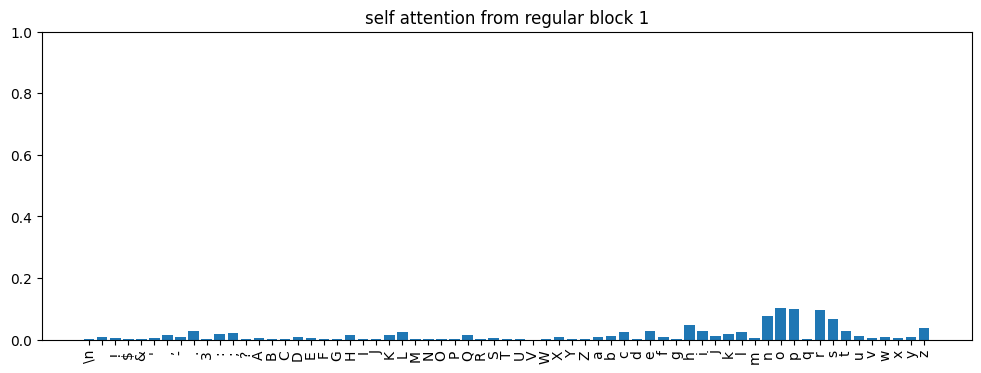

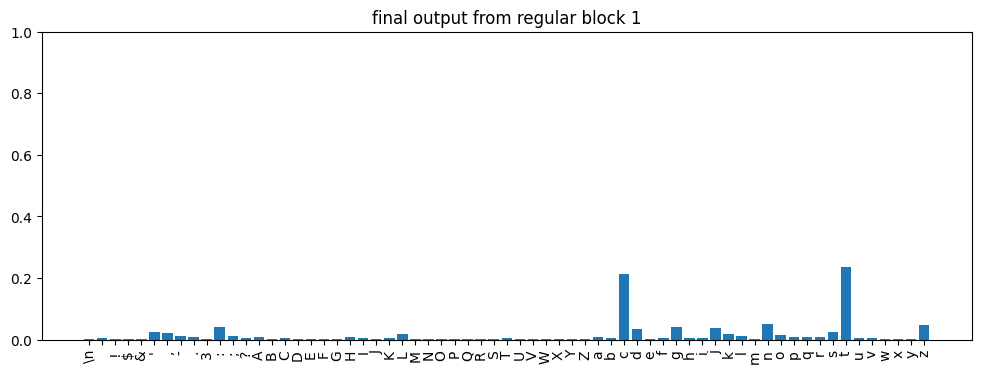

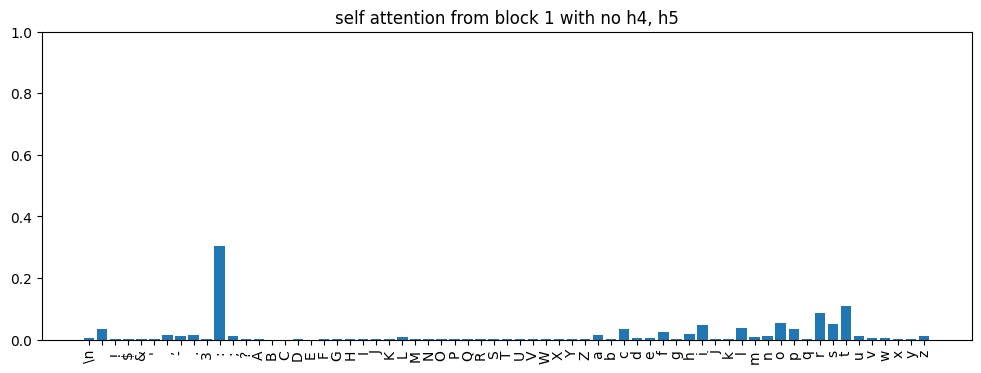

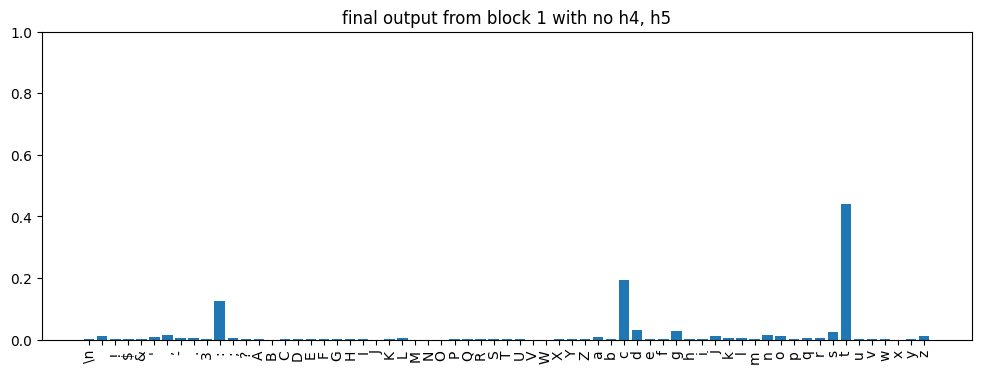

In [ ]:
# Visualize effect of disabling heads
block0_reg, _ = copy_block_from_model(block_idx=0)
block1, io_accessor1 = copy_block_from_model(block_idx=0)

block1_noh4h5, io_accessor_noh4h5 = copy_block_from_model_and_disable_heads(block_idx=1, disable_heads=[4, 5])

x = encode_input('Citizen')
x = block0_reg(x)

block1(x)
block1_noh4h5(x)

sa_output1 = io_accessor1.output('sa')
sa_output_noh4h5 = io_accessor_noh4h5.output('sa')

plot_probs(probs(sa_output1)[0], title="self attention from regular block 1")
plot_probs(probs(io_accessor1.output('.'))[0], title='final output from regular block 1')
plot_probs(probs(sa_output_noh4h5)[0], title="self attention from block 1 with no h4, h5")
plot_probs(probs(io_accessor_noh4h5.output('.'))[0], title="final output from block 1 with no h4, h5")
